## ANALYSIS FOR COMPETITIVENESS OF A DECK

In [1]:
import pandas as pd
import numpy as np

unleveled_ranks = pd.read_csv("../csv_sources/ranks_unleveled.csv").drop(["index", "levelSum", "crowns"], axis="columns")
unleveled_ranks

,rank,troop,building,spell,common,rare,epic,legendary,elixir,conf_synergy,...,totalDMG,avgAS,totalUnitsCount,abilityCount,avgRange,totalGroundT,totalAirT,totalBuildingT,totalBuffCount,totalProjectiles
0,Fun Deck,6,0,2,0,1,4,3,3.250,1117.639312,...,1919,1.233333,20,4,2712.50,8,3,1,1,1
1,Competitive,5,0,3,1,1,4,2,3.375,2865.990531,...,1859,1.420000,19,2,2712.50,8,3,0,0,3
2,Competitive,5,1,2,1,2,3,2,4.250,3980.516610,...,2028,1.316667,5,3,2018.75,7,5,1,2,0
3,Competitive,7,1,0,3,3,2,0,4.875,0.000000,...,2305,2.075000,27,1,1925.00,8,2,2,0,0
4,Competitive,7,0,1,4,2,1,1,3.750,1389.332225,...,2267,1.428571,11,2,4175.00,8,6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,Fun Deck,6,0,2,2,2,3,1,3.875,0.000000,...,1677,1.183333,22,2,1750.00,8,3,1,0,2
10096,Fun Deck,7,0,1,1,2,5,0,3.750,0.000000,...,4315,1.814286,21,1,2012.50,8,2,1,0,1
10097,Fun Deck,6,0,2,0,3,4,1,4.250,0.000000,...,3075,1.416667,20,2,2087.50,8,3,0,0,2
10098,Fun Deck,6,1,1,1,1,3,3,4.250,3856.801490,...,2264,1.457143,24,2,4175.00,8,3,1,0,1


In [2]:
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from random import randrange
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

y = np.array([x for x in unleveled_ranks["rank"]])
X = np.array([x for x in unleveled_ranks.drop(["rank"], axis="columns").values])

scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score, average='macro', zero_division=0),
    'Recall': make_scorer(recall_score, average="macro", zero_division=0),
    'F-Measure': make_scorer(f1_score, average="macro", zero_division=0)
}

def converter(df):
    scores = {
        'fit_time': df['fit_time'],
        'score_time': df['score_time'],
        'test_Accuracy': df['test_Accuracy'],
        'test_Precision': df['test_Precision'],
        'test_Recall': df['test_Recall'],
        'test_F-Measure': df['test_F-Measure']
    }
    estimators = df['estimator']
    accuracies = df['test_Accuracy']
    for key in scores.keys():
        if "test_" in key:
            scores[key] = [f"{scores[key].mean() * 100: .2f}%"]
        else:
            scores[key] = [f"{scores[key].mean(): .2f}"]
    return [pd.DataFrame(scores), estimators, accuracies]

def feat_extraction(estimators, avoid_scores = False):
    features_per_fold = {}
    fold_index = 0
    for estim in estimators:
        fold_index += 1
        feature = 0
        sel_features = {}
        feat_scores = []
        if not avoid_scores:
            feat_scores = estim['feat_sel'].scores_
        for selected in estim['feat_sel'].get_support():
            feature+=1
            if(selected == True):
                if len(feat_scores) > 0:
                    sel_features[unleveled_ranks.columns[feature]] = [feat_scores[feature-1]]
                else:
                    sel_features[unleveled_ranks.columns[feature]] = True
        features_per_fold[f"fold_{fold_index}"] = sel_features
    return pd.DataFrame(features_per_fold).transpose()

skf = StratifiedKFold(n_splits=10, shuffle=True)
metricsComparison = {}

## J48

In [3]:
j48_pip = Pipeline([
    ('clf', DecisionTreeClassifier())
])
j48_kbest_pip = Pipeline([
    ('feat_sel', SelectKBest(chi2, k=15)),
    ('clf', DecisionTreeClassifier())
])
j48_vt_pip = Pipeline([
    ('feat_sel', VarianceThreshold(threshold=0.7)),
    ('clf', DecisionTreeClassifier())
])

In [4]:
j48u = cross_validate(j48_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(j48u)

metricsComparison['J48'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.09,0.02,79.35%,77.25%,77.16%,77.17%


In [5]:
j48u_kbest = cross_validate(j48_kbest_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(j48u_kbest)

feature_scores = feat_extraction(unleveled_estimators)

metricsComparison['J48+KBest'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.38,0.02,79.21%,77.08%,76.92%,76.99%


In [6]:
feature_scores.transpose()

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
troop,[247.11636565264223],[241.6283503948411],[246.64228584748608],[239.70145251735715],[241.26316040151156],[234.43773481831607],[249.26232815489803],[242.13136417231516],[238.51982241054316],[230.16798215692478]
building,[277.89217687074824],[261.31354991608254],[286.53568000077655],[265.83601779701775],[283.19486712345025],[260.2332093537458],[275.9711443182572],[256.10196363252834],[264.9948729984873],[256.1639077250605]
spell,[390.234665966784],[385.5858703274101],[385.1420524674413],[378.45555334692267],[372.63934522580325],[370.6140119828608],[397.68891323019795],[390.3020255929539],[378.1500644876713],[365.26664588259086]
common,[727.6136348789212],[691.2198534467693],[702.893948055136],[713.9106187727822],[695.2338409045952],[720.3829527679142],[720.9960767306086],[712.3072816052477],[691.6092396789421],[718.8061155363446]
epic,[1228.084600792421],[1187.6822152916825],[1202.9388033512748],[1177.0629843753682],[1209.0534601415998],[1215.1888695977066],[1240.8049971111498],[1214.6457630902796],[1192.9959099196233],[1213.2493858652522]
legendary,[250.36180791472236],[264.14257708523553],[257.0090922362487],[242.68288084520293],[275.3947079016818],[278.13536644566335],[265.82921550069966],[278.11467735814506],[268.2264470661273],[274.9837511842787]
conf_synergy,[13756516.379369639],[13403767.384044876],[13245854.993421242],[13116903.13709436],[13362314.882314902],[13512001.45837219],[13324389.416845536],[13447711.274938421],[12924049.459012661],[13121038.780837234]
lift_synergy,[393600528.6441698],[379332918.37655544],[374541267.79590374],[368251284.2843412],[375975284.0816587],[380857087.79314],[375228524.20556504],[382954207.6885514],[362180217.496987],[370140206.61477953]
avgSpeed,[254.56407443172606],[244.66772110197337],[265.93840043918124],[258.9357144156537],[288.6159040540191],[260.1702388000205],[270.4793422799823],[289.60048116766154],[271.83664744340325],[275.50198640776154]
avgSpellDuration,[900.022116530781],[789.8985206624366],[983.2035410253185],[784.8341342075685],[931.8340110515853],[759.457309719028],[827.3833425152943],[724.4787884039903],[808.43411853728],[747.4275579749146]


In [7]:
j48u_vt = cross_validate(j48_vt_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(j48u_vt)

metricsComparison['J48+VT'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.08,0.01,79.21%,77.07%,76.99%,77.02%


<AxesSubplot:>

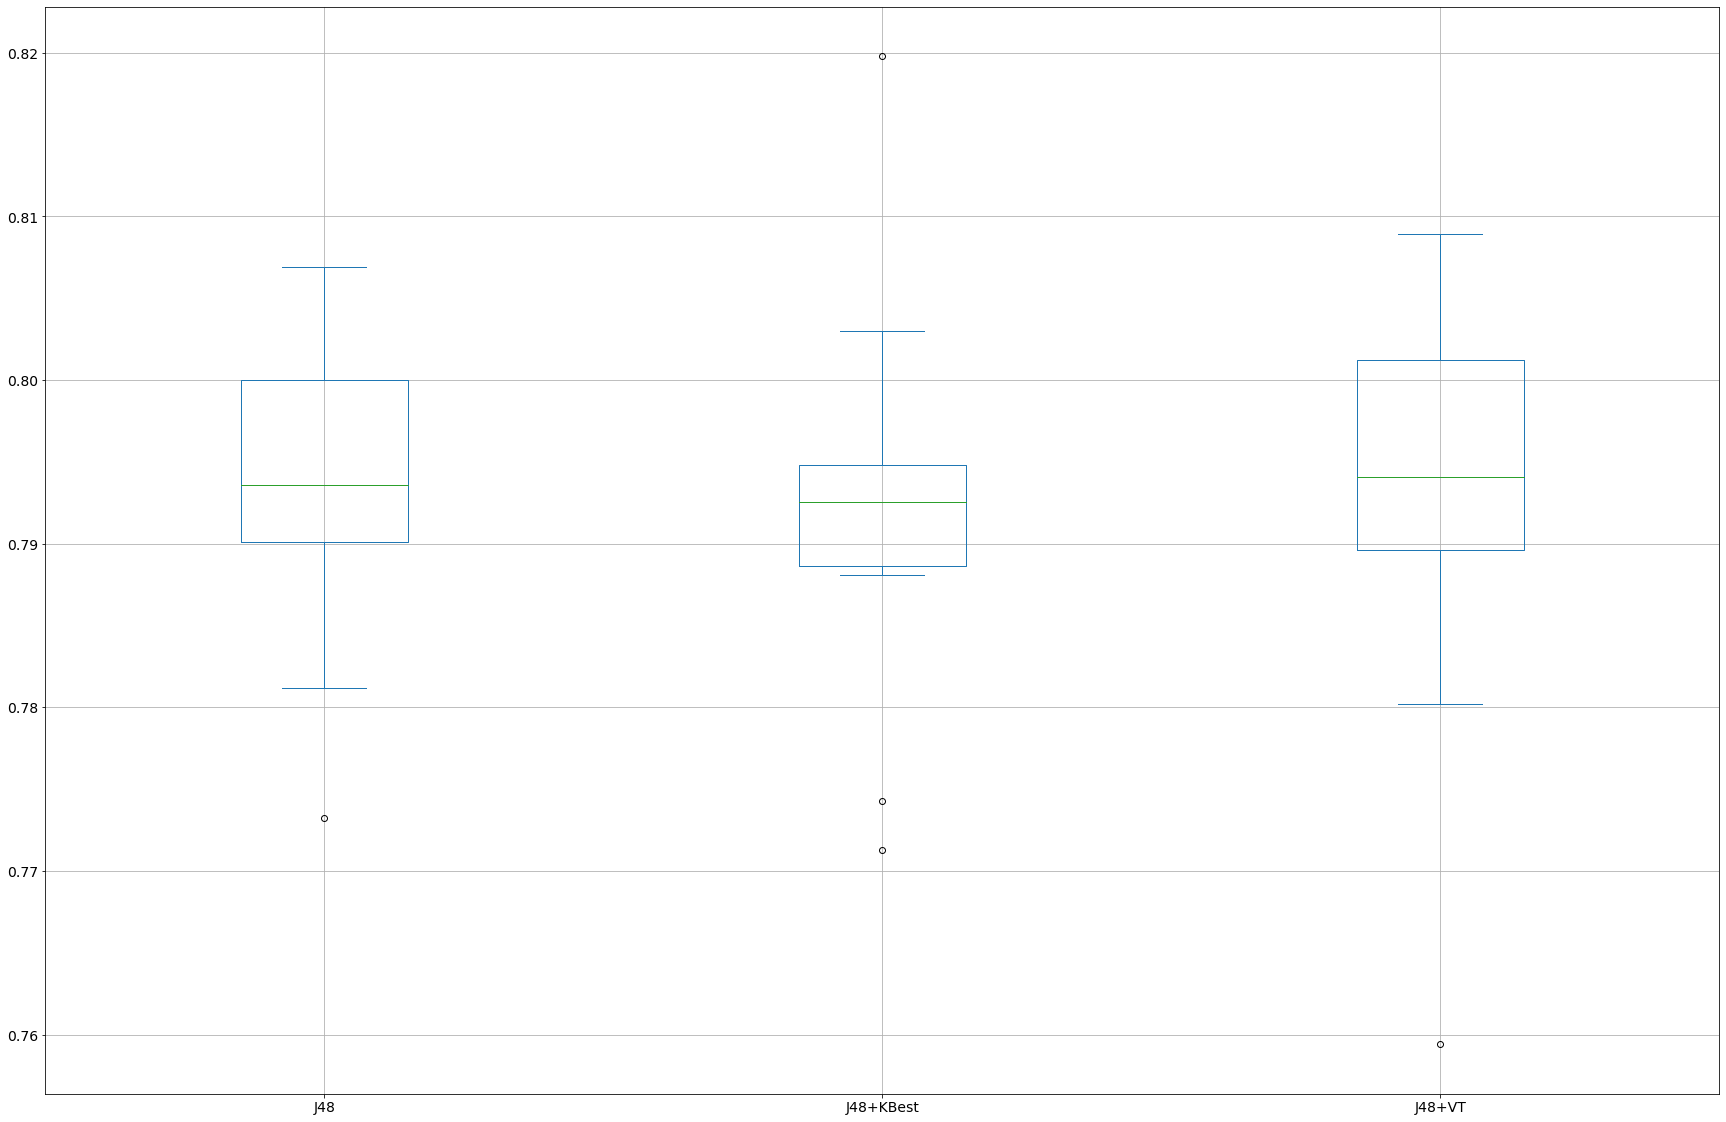

In [8]:
final_dict = {}
for metric in metricsComparison:
    for m in metricsComparison[metric]:
        final_dict[metric] = m
mc_df = pd.DataFrame(final_dict)
mc_df.plot.box(return_type='axes', figsize=(30,20), grid=True, fontsize=14)

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
metricsComparison = {}

rf_pip = Pipeline([
    ('clf', RandomForestClassifier(n_estimators=100))
])
rf_kbest_pip = Pipeline([
    ('feat_sel', SelectKBest(chi2, k=15)),
    ('clf', RandomForestClassifier(n_estimators=100))
])
rf_VT_pip = Pipeline([
    ('feat_sel', VarianceThreshold(threshold=0.7)),
    ('clf', DecisionTreeClassifier())
])

In [10]:
rfu = cross_validate(rf_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(rfu)

metricsComparison['RF'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,1.16,0.04,85.52%,84.71%,82.80%,83.59%


In [11]:
rfu_kbest = cross_validate(rf_kbest_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(rfu_kbest)

metricsComparison['RF+KBest'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,1.14,0.04,84.95%,84.02%,82.20%,82.96%


In [12]:
rfu_vt = cross_validate(rf_VT_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(rfu_vt)

metricsComparison['RF+VT'] = [unleveled_accuracies]

features = unleveled_estimators[0]["feat_sel"].get_support()

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.08,0.01,78.89%,76.72%,76.60%,76.64%


In [13]:
feature = 0
sel_features = []
for selected in features:
    feature += 1
    if features[feature-1]:
        sel_features.append(unleveled_ranks.columns[feature])

print(sel_features)
print(len(sel_features))

['troop', 'spell', 'common', 'rare', 'epic', 'legendary', 'conf_synergy', 'lift_synergy', 'avgSpeed', 'avgSpellDuration', 'totalHP', 'totalDMG', 'totalUnitsCount', 'abilityCount', 'avgRange', 'totalAirT', 'totalProjectiles']
17


<AxesSubplot:>

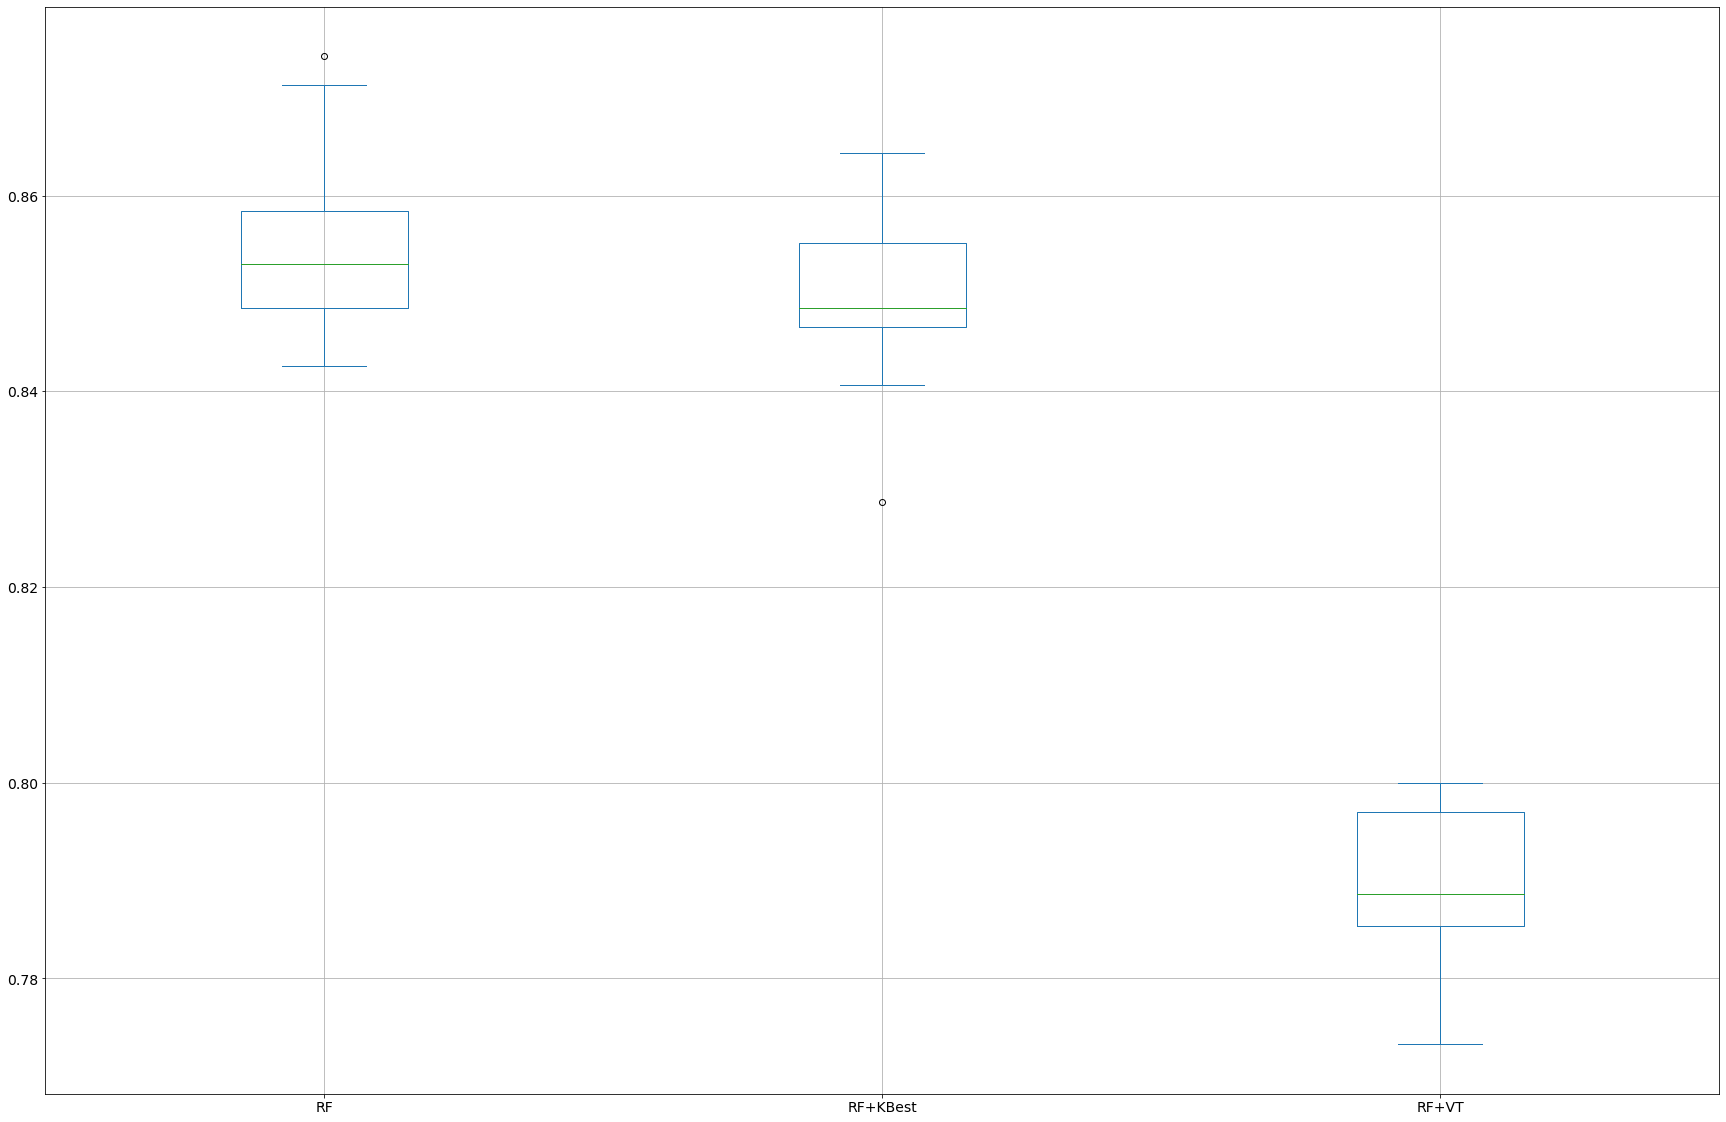

In [14]:
final_dict = {}
for metric in metricsComparison:
    for m in metricsComparison[metric]:
        final_dict[metric] = m
mc_df = pd.DataFrame(final_dict)
mc_df.plot.box(return_type='axes', figsize=(30,20), grid=True, fontsize=14)

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

metricsComparison = {}

knn_pip = Pipeline([
    ('clf', KNeighborsClassifier())
])
knn_kbest_pip = Pipeline([
    ('feat_sel', SelectKBest(chi2, k=15)),
    ('clf', KNeighborsClassifier())
])
knn_VT_pip = Pipeline([
    ('feat_sel', VarianceThreshold(threshold=0.7)),
    ('clf', KNeighborsClassifier())
])

In [16]:
knnu = cross_validate(knn_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(knnu)

metricsComparison['KNN'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.01,0.37,71.50%,68.40%,67.65%,67.92%


In [17]:
knnu_kbest = cross_validate(knn_kbest_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(knnu_kbest)

metricsComparison['KNN+KBest'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.11,0.08,71.31%,68.16%,67.42%,67.71%


In [18]:
knn_vt = cross_validate(knn_VT_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(knn_vt)

metricsComparison['KNN+VT'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.02,0.39,71.39%,68.26%,67.50%,67.80%


<AxesSubplot:>

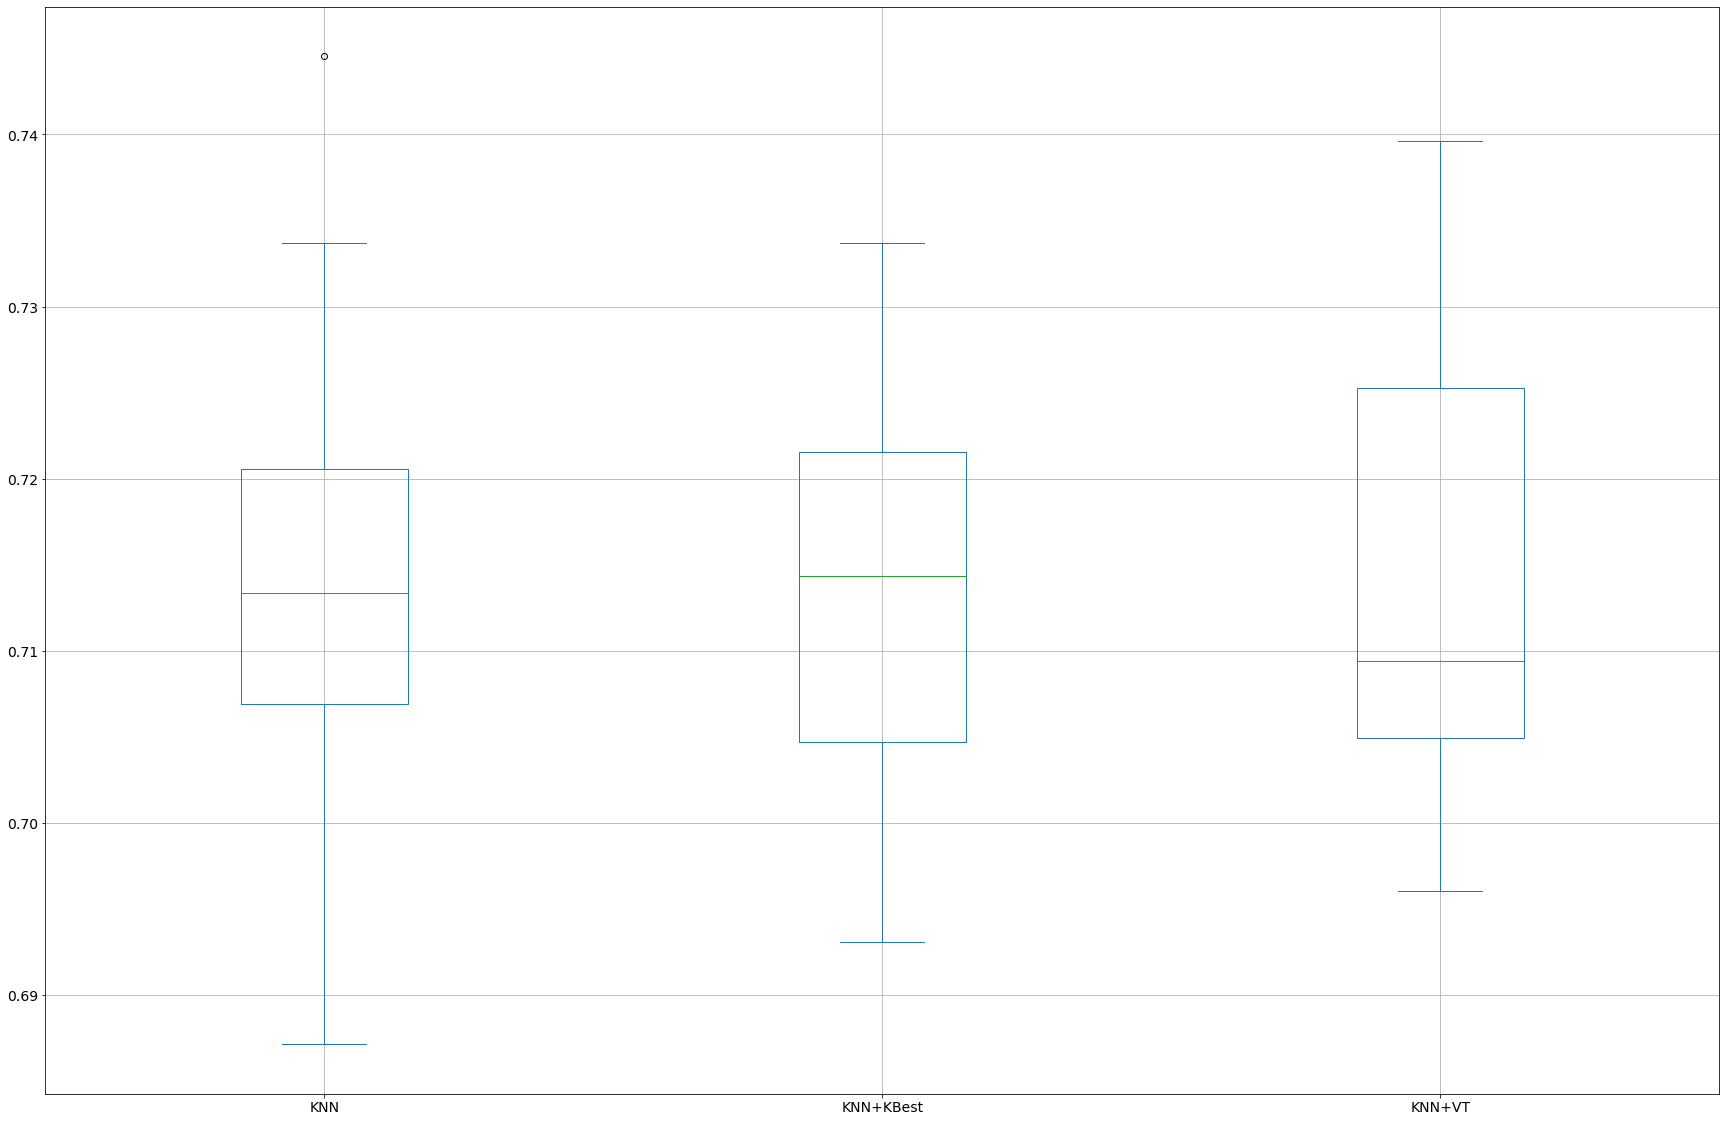

In [19]:
final_dict = {}
for metric in metricsComparison:
    for m in metricsComparison[metric]:
        final_dict[metric] = m
mc_df = pd.DataFrame(final_dict)
mc_df.plot.box(return_type='axes', figsize=(30,20), grid=True, fontsize=14)

### NAIVE BAYES

In [20]:
from sklearn.naive_bayes import GaussianNB

metricsComparison = {}

nb_pip = Pipeline([
    ('clf', GaussianNB())
])
nb_kbest_pip = Pipeline([
    ('feat_sel', SelectKBest(chi2, k=15)),
    ('clf', GaussianNB())
])
nb_VT_pip = Pipeline([
    ('feat_sel', VarianceThreshold(threshold=0.7)),
    ('clf', GaussianNB())
])

In [21]:
nb = cross_validate(nb_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(nb)

metricsComparison['NB'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.01,0.01,51.69%,65.72%,61.62%,50.80%


In [22]:
nb_kbest = cross_validate(nb_kbest_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(nb_kbest)

metricsComparison['NB+KBest'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.03,0.02,51.75%,65.81%,61.67%,50.86%


In [23]:
nb_VT = cross_validate(nb_VT_pip, X, y, scoring=scoring, cv=skf, n_jobs=4, return_estimator=True)

mean_unleveled, unleveled_estimators, unleveled_accuracies = converter(nb_VT)

metricsComparison['NB+VT'] = [unleveled_accuracies]

mean_unleveled

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_F-Measure
0,0.02,0.01,51.90%,65.88%,61.79%,51.03%


<AxesSubplot:>

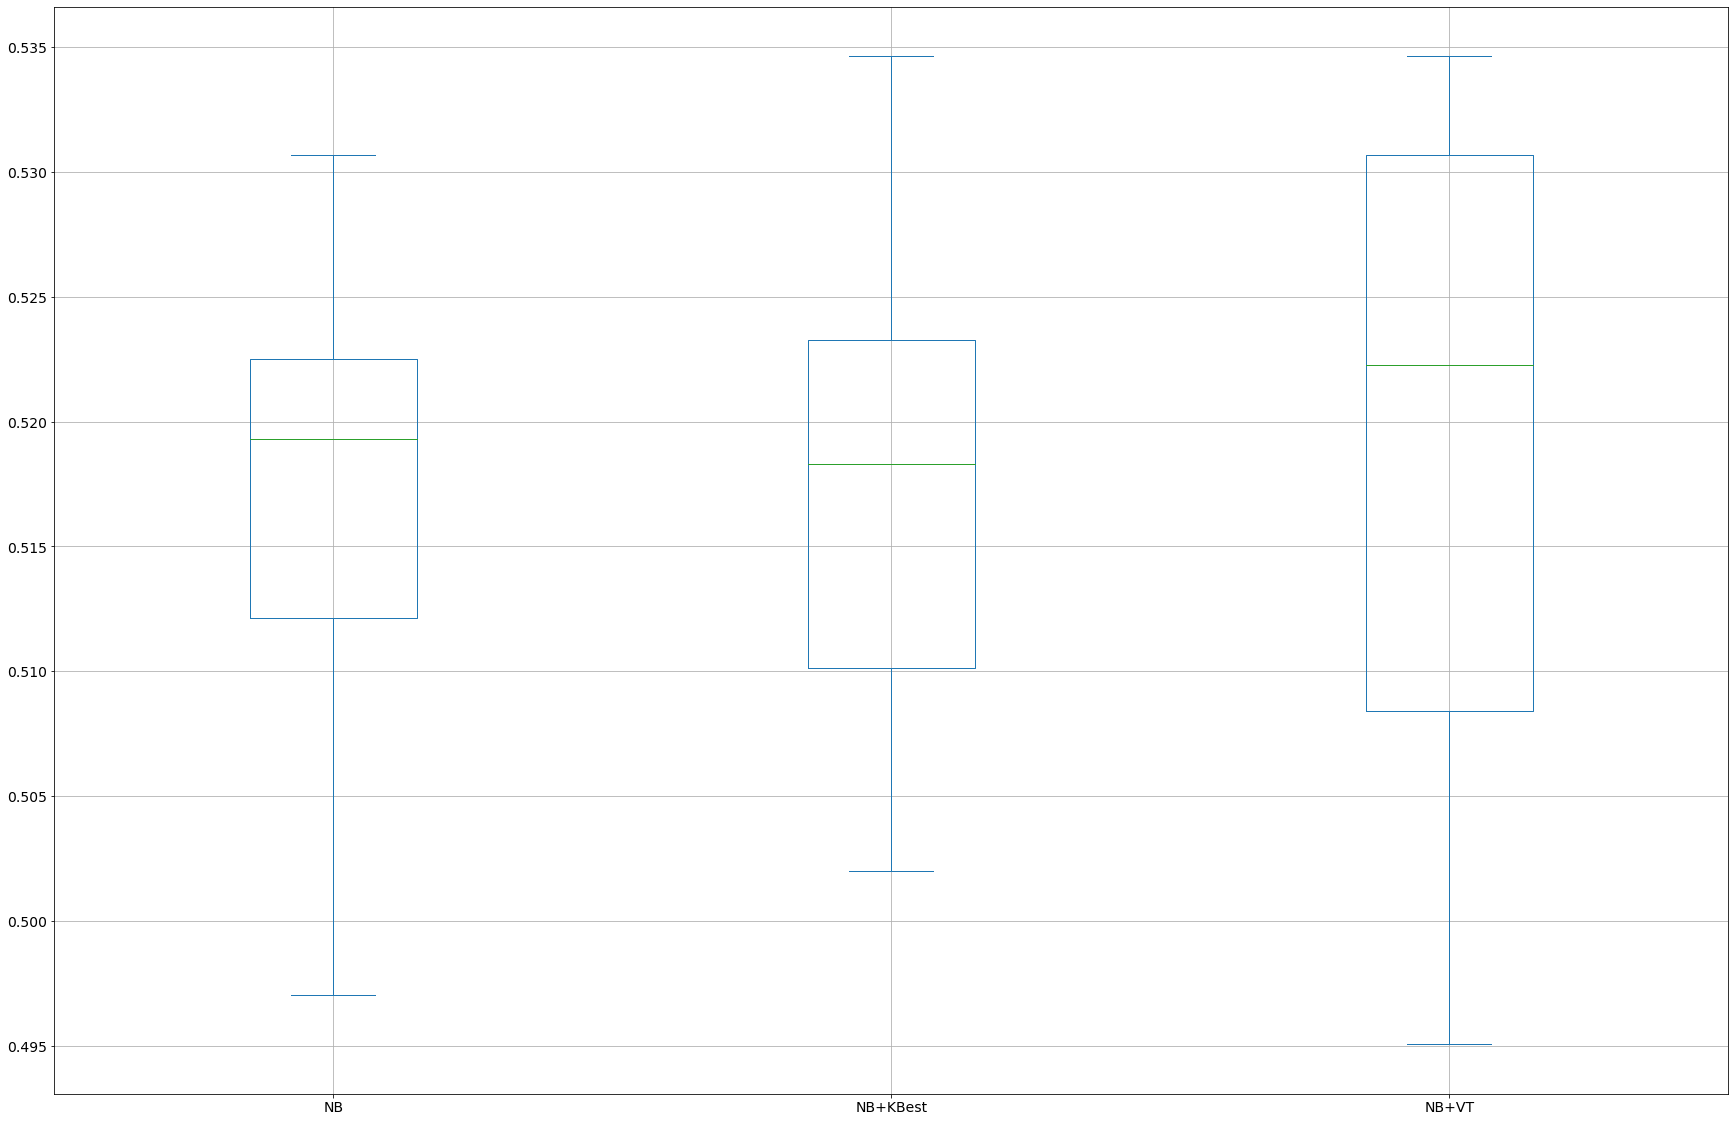

In [24]:
final_dict = {}
for metric in metricsComparison:
    for m in metricsComparison[metric]:
        final_dict[metric] = m
mc_df = pd.DataFrame(final_dict)
mc_df.plot.box(return_type='axes', figsize=(30,20), grid=True, fontsize=14)